In [1]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

In [ ]:
#%cd ..

# Import Data

In [5]:
df, answers, info_dict = get_cluster_input_data(pca_data=False, masks=True, experimental=True)
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_private,Q14_ocupation_unemployed,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,0,0,1,0,0,0,2.0,4.0,4.0,2.0
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,0,0,1,0,0,0,2.0,4.0,2.0,4.0
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,0,0,1,0,0,0,NaN,NaN,NaN,NaN
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,0,0,1,2.0,4.0,NaN,NaN


In [6]:
info_dict

{'cluster_input_cols': ['Q1_2_covid_is_threat',
  'Q2_1_easy_to_follow_advice',
  'Q2_2_can_follow_advice_if_wanted',
  'Q2_3_if_follow_advice_safe',
  'Q2_4_if_follow_advice_others_safe',
  'Q2_5_follow_advice_relationships_impared',
  'Q2_6_follow_advice_life_degraded',
  'Q3_1_aware_hand_hygiene',
  'Q3_2_avoid_contact',
  'Q3_3_ensure_frequent_cleaning',
  'Q3_4_avoid_risk_groups',
  'Q3_5_keep_distance',
  'Q3_6_avoid_crowds',
  'Q3_7_minimize_activities_w_contact',
  'Q5_4_yourself_kept_distance',
  'Q5_5_feel_urge_scold',
  'Q6_2_advices_important',
  'Q6_3_others_can_avoid_spreading',
  'Q6_5_ownership_of_advice',
  'Q6_6_clear_information_on_advice_reason',
  'Q6_7_advice_limits_daily_activities',
  'Q6_9_trust_political_strategy',
  'Q10_education',
  'Q11_nr_members_household',
  'Q12_nr_children_household',
  'age_num'],
 'data_path': 'data/preprocessing/220216_preprocessed_data_missing_data.csv',
 'pca_data': False,
 'scaler_type': 'MinMaxScaler()'}

In [7]:
answers_sampled = pd.DataFrame(answers).sample(50000).to_numpy()

# GM clustering

## Probabilistic Approach to determine number of clusters

### Prior Distribution

In [8]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

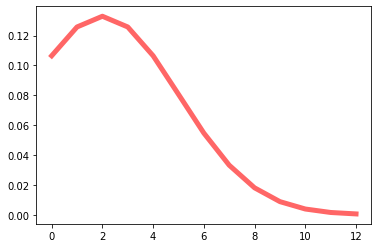

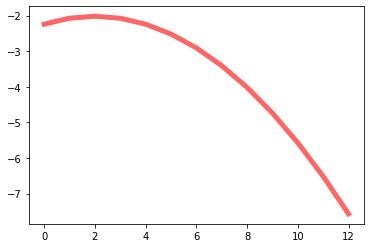

In [9]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

### Calculate and Plot

In [10]:
# Set up a range of cluster numbers to try
n_range = range(1,15)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6)
    gm.fit(answers_sampled)
    
    # Calculate Log Probabilities
    log_prob_data_given_model = -gm.bic(answers_sampled) # Computes the per-sample average log-likelihood of the given data X - can be approximated by using BIC Score
    log_prob_model = prior_dist.logpdf(n)

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)

100%|██████████| 14/14 [18:52<00:00, 80.92s/it] 


In [11]:
def min_max_scaler(input_list):
  input_array = np.array(input_list)
  input_array_scaled = (input_array - input_array.min()) / (input_array.max() - input_array.min())
  return input_array_scaled

In [12]:
log_prob_data_given_model_scaled = min_max_scaler(list_log_prob_data_given_model) # multiply with -1 so that we get a maximization problem
log_prob_model_scaled = min_max_scaler(list_log_prob_model)
score = log_prob_data_given_model_scaled + log_prob_model_scaled
score

array([0.99305556, 1.22639261, 1.34689789, 1.50915381, 1.44068107,
       1.60834685, 1.58973136, 1.48445381, 1.45351189, 1.34748037,
       1.35546817, 1.25632607, 1.09004548, 1.        ])

Text(0.5, 1.0, 'Probabilistic Evaluation')

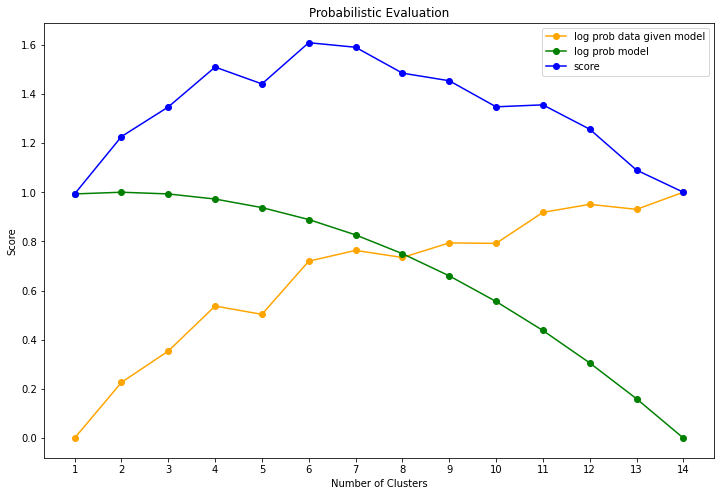

In [13]:
# Plot Probabilistic Evaluation
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, log_prob_data_given_model_scaled, '-o', color='orange', label='log prob data given model')
ax.plot(n_range, log_prob_model_scaled, '-o', color='green', label='log prob model')
ax.plot(n_range, score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

In [14]:
n_clusters = n_range[np.argmax(score)]
n_clusters

6

## GM fit with determined number of cluster

In [15]:
n_clusters = 6
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6)
gm.fit(answers)

GaussianMixture(n_components=6, n_init=6, random_state=123)

In [16]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,gender,postnr,region,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,...,Q14_ocupation_employee_public,Q14_ocupation_self_employed,Q14_ocupation_student,Q14_ocupation_other,Q15_economic_spectrum,Q15_social_spectrum,Q16_economic_spectrum,Q16_social_spectrum,group,group_prob
0,Man,2830,Capital,4.796778,5.0,7.0,4.0,7.0,4.0,5.0,...,1,0,0,0,2.0,4.0,4.0,2.0,3,0.999719
1,Woman,4654,Zealand,7.000000,7.0,7.0,5.0,7.0,6.0,5.0,...,1,0,0,0,2.0,4.0,2.0,4.0,5,1.000000
2,Woman,7451,Central,7.000000,7.0,7.0,7.0,7.0,4.0,3.0,...,1,0,0,0,NaN,NaN,NaN,NaN,3,0.999413
3,Man,4700,Zealand,6.000000,1.0,7.0,2.0,1.0,7.0,4.0,...,0,0,0,0,NaN,NaN,NaN,NaN,1,0.999617
4,Man,4000,Zealand,5.000000,1.0,1.0,2.0,1.0,2.0,2.0,...,0,0,0,1,2.0,4.0,NaN,NaN,2,1.000000


## Save for general clustering evaluation

In [17]:
df.to_csv('data/clustering/220405_gmm_clustered_experimental.csv', index=False)

## Dirichlet Process
n_components=20 --> 4 weights that are smaller than 0.01

In [ ]:
n_comp = 10
bgm = BayesianGaussianMixture(n_components=n_comp, random_state=123, n_init=100, weight_concentration_prior_type='dirichlet_process', weight_concentration_prior= 100)
bgm.fit(answers_sampled)

BayesianGaussianMixture(n_components=10, n_init=100, random_state=123,
                        weight_concentration_prior=100)

In [ ]:
DPGMM = BayesianGaussianMixture(n_components=15, 
                                                max_iter=100000000,
                                                n_init=10,
                                                tol=1e-5, 
                                                init_params='kmeans', 
                                                weight_concentration_prior_type='dirichlet_process',
                                                weight_concentration_prior=1/10)
DPGMM.fit(answers_sampled)

BayesianGaussianMixture(max_iter=100000000, n_components=15, n_init=10,
                        tol=1e-05, weight_concentration_prior=0.1)

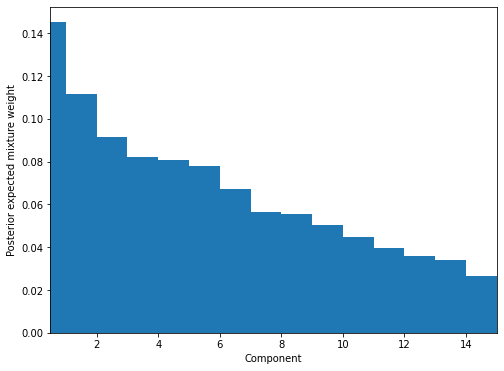

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [ ]:
#n_to_select = 8
w = (-DPGMM.weights_).argsort()[:n_to_select]

In [ ]:
w

In [ ]:
df['group'] = DPGMM.predict(answers)
df['group_prob'] = pd.DataFrame(DPGMM.predict_proba(answers)).max(axis=1)
df.head()

In [ ]:
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

In [ ]:
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

In [ ]:
bgm.weights_ # 10 comp, weight_concentration_prior = 0.01

array([0.09972451, 0.21158215, 0.02671422, 0.08405336, 0.06169124,
       0.04720168, 0.10768013, 0.14968287, 0.13016821, 0.08150162])

In [ ]:
bgm.means_

array([[5.98973420e-01, 8.27125717e-01, 9.99985800e-01, 8.03490588e-01,
        9.99986485e-01, 5.23705233e-01, 3.84195303e-01, 7.77848472e-01,
        6.73037734e-01, 5.70717866e-01, 7.42757909e-01, 6.81892157e-01,
        6.60773135e-01, 6.09051551e-01, 7.43799172e-01, 2.04374130e-01,
        8.05546728e-01, 5.90505866e-01, 7.47577430e-01, 7.13403989e-01,
        4.79381704e-01, 6.81496596e-01, 4.46020082e-01],
       [6.14103597e-01, 7.18430877e-01, 8.45995352e-01, 7.02855527e-01,
        8.33390187e-01, 6.27353529e-01, 4.89142901e-01, 8.58816394e-01,
        7.48501366e-01, 6.38480870e-01, 8.20576417e-01, 7.39849540e-01,
        7.18544313e-01, 6.99116459e-01, 7.79198550e-01, 2.73167014e-01,
        7.70819149e-01, 5.89461123e-01, 7.30673030e-01, 6.22360378e-01,
        6.22390141e-01, 6.06712979e-01, 9.99829906e-01],
       [5.80270731e-01, 6.63134946e-01, 7.48553556e-01, 6.62096828e-01,
        7.83139966e-01, 5.81117107e-01, 4.66936204e-01, 8.33342114e-01,
        6.95065484e-01

In [ ]:
bgm.n_features_in_

23

# Specific Clustering Method Analysis

In [ ]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [ ]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

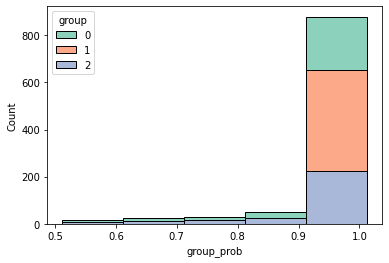

In [ ]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

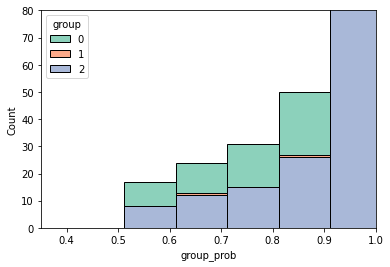

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

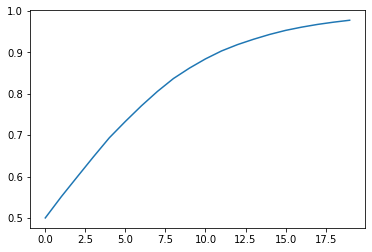

In [ ]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()